<div class="alert alert-block alert-info">
    <h1>Importing packages</h1>
 </div>

In [1]:
%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import os
import sys
import pywt
import scipy
import warnings
import tensorflow as tf
import xgboost as xgb
from scipy.io import loadmat, savemat
from scipy import signal
from scipy import stats
from IPython.display import Image
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from numpy import linalg as LA 
from collections import Counter, defaultdict
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
#from scikeras.wrappers import KerasClassifier

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-block alert-info">
    <h1>Reading files of signals</h1>
 </div> 

In [54]:
#path general and files of signals
path_denoised_dwt = './dataset/MIT_denoised_with_normalization/'
path_denoised = './dataset/MIT_denoised_without_normalization/'
path_denoised_savgol = './dataset/MIT_denoised_savgol/'
path_normalized = './dataset/MIT_normalized/'
path = './dataset/MIT/'
files_mat = os.listdir(path)
files_train = ['101.mat','106.mat','108.mat','109.mat','112.mat','114.mat','115.mat',
              '116.mat','118.mat','119.mat','122.mat','124.mat','201.mat','203.mat',
              '205.mat','207.mat','208.mat','209.mat','215.mat','220.mat','223.mat','230.mat']
files_test = ['100.mat','103.mat','105.mat','111.mat','113.mat','117.mat','121.mat',
              '123.mat','200.mat','202.mat','210.mat','212.mat','213.mat','214.mat',
              '219.mat','221.mat','222.mat','228.mat','231.mat','232.mat','233.mat','234.mat']

<div class="alert alert-block alert-info">
    <h1>Normalization using Z-score</h1>
</div>

$\textrm{Values normalized} = \dfrac{\textrm{signal values} - \textrm{mean signal of values}}{\textrm{standard deviation of signal values}}$
 

In [10]:
def normalize_beats(path_save, path_open, list_files):
    for file in list_files:

        struct = loadmat(path_open + file) #loading the file
        data = struct['individual'][0][0] #loading info of the signal
        ecg = data['signal_r'][:, 1] #reading lead II

        norm_signal = stats.zscore(ecg) #applying zscore in signal

        savemat(path_save+file, {'data':norm_signal}) #save the signal

In [24]:
normalize_beats(path_normalized,path,files_mat)

<div class="alert alert-block alert-info">
    <h1>Removing (high-frequency) noise using DWT </h1>
</div>

In [73]:
def filter_remove_noise(signal, thresh = 0.4, wavelet="sym20"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per")
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

In [76]:
#aplicando a remoção de ruído com DWT without normalized signals
def remove_noise(path_save, path_open, list_files):
    
    for file in list_files:

        struct = loadmat(path_open + file) #loading the file
        data = struct['individual'][0][0] #loading info of the signal
        ecg = data['signal_r'][:, 1] #reading lead II

        denoised_signal = filter_remove_noise(ecg,0.15) #applying DWT denoise

        savemat(path_save+file, {'data':denoised_signal})    

In [72]:
#aplicando a remoção de ruído com DWT with normalized signals
def remove_noise_dwt(path_save, path_open, list_files):
    
    for file in list_files:

        struct = loadmat(path_open + file) #loading the file
        ecg = struct['data'][0] #loading info of the signal

        denoised_signal = filter_remove_noise(ecg,0.15) #applying DWT denoise

        savemat(path_save+file, {'data':denoised_signal})    

In [ ]:
remove_noise_dwt(path_denoised_dwt,path_normalized,files_mat)

In [78]:
remove_noise(path_denoised,path,files_mat)

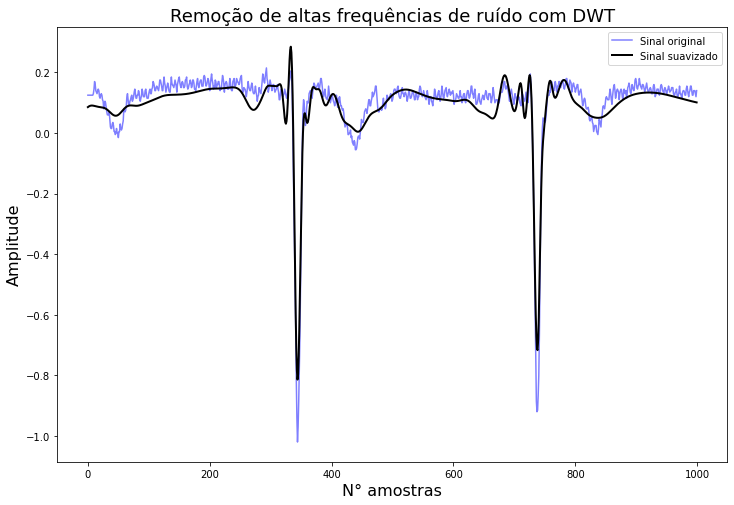

In [3]:
struct = loadmat(path + files_mat[0]) #loading the file
data = struct['individual'][0][0] #loading info of the signal
ecg = data['signal_r'][:, 1] #reading lead II

struct_denoised = loadmat(path_denoised+files_mat[0]) #loading the file
ecg_denoised = struct_denoised['data'][0] #loading info of the signal

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ecg[0:1000], color="b", alpha=0.5, label='Sinal original')
ax.plot(ecg_denoised[0:1000], 'k', label='Sinal suavizado', linewidth=2)
ax.legend()
#ax.set_title('Remoção de altas frequências de ruído com DWT', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=16)
ax.set_xlabel('N° amostras', fontsize=16)
#plt.savefig('denoised_example.pdf', dpi=300)
plt.show()

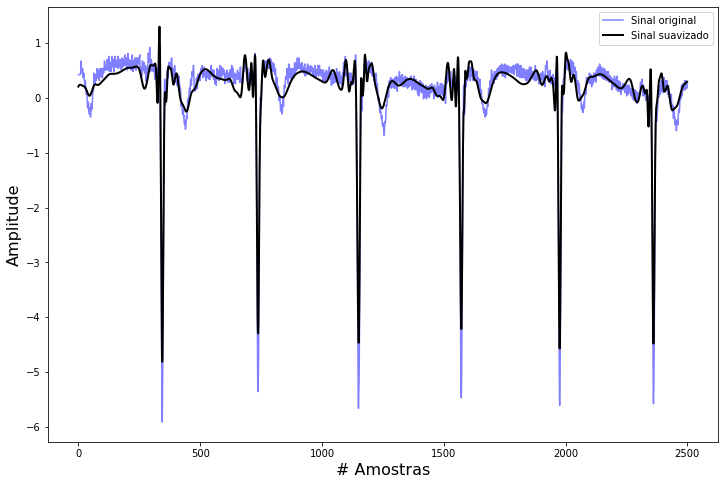

In [55]:
normalized_signal = loadmat(path_normalized+files_mat[0]) #loading the file
ecg_normalized = normalized_signal['data'][0] #loading info of the signal


struct_denoised = loadmat(path_denoised_dwt+files_mat[0]) #loading the file
ecg_denoised = struct_denoised['data'][0] #loading info of the signal

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ecg_normalized[0:2500], color="b", alpha=0.5, label='Sinal original')
ax.plot(ecg_denoised[0:2500], 'k', label='Sinal suavizado', linewidth=2)
ax.legend()
#ax.set_title('Remoção de altas frequências de ruído com DWT', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=16)
ax.set_xlabel('# Amostras', fontsize=16)
plt.savefig('./images/denoised_example.pdf', dpi=300)
plt.show()

<div class="alert alert-block alert-info">
    <h1>Removing (high-frequency) noise using Savitzky-Golay filter </h1>
</div>

In [32]:
#aplicando a remoção de ruído com Savgol
def remove_noise_savgol(path_save, path_open, list_files):
    
    for file in list_files:

        struct = loadmat(path_open+file) #loading the file
        ecg = struct['data'][0] #loading info of the signal

        denoised_signal_savgol = signal.savgol_filter(ecg,25,3) #applying savitzky-Golay

        savemat(path_save+file, {'data':denoised_signal_savgol}) 

In [34]:
remove_noise_savgol(path_denoised_savgol,path_normalized,files_mat)

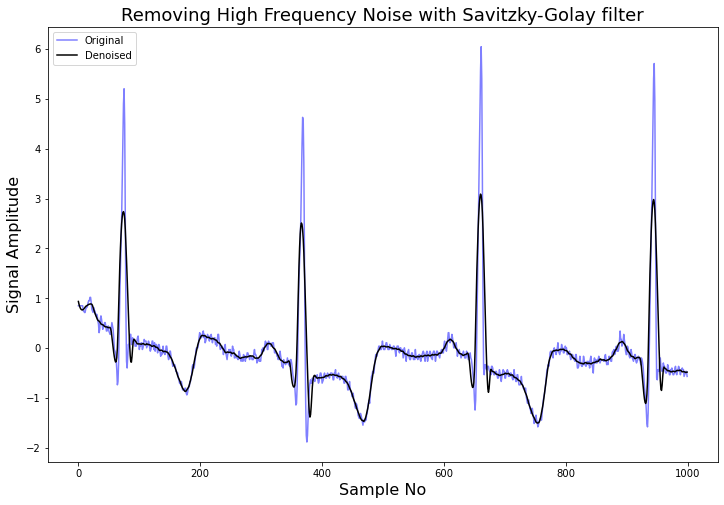

In [6]:
struct_denoised_savgol = loadmat(path_denoised_savgol+files_mat[0]) #loading the file
ecg_denoised_savgol = struct_denoised_savgol['data'][0] #loading info of the signal

plt.figure(figsize=(12,8))
plt.plot(ecg_normalized[0:1000],color='b', alpha=0.5, label='Original')
plt.plot(ecg_denoised_savgol[0:1000], color='k', label='Denoised')
plt.title('Removing High Frequency Noise with Savitzky-Golay filter', fontsize=18)
plt.ylabel('Signal Amplitude', fontsize=16)
plt.xlabel('Sample No', fontsize=16)
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    <h1>Segmentation </h1>
</div>

In [6]:
def load_signals(path, path_denoised, list_ecgs, size_beat):
    dict_signals = defaultdict(list) #dict to load beats
    
    for file in list_ecgs:               
     
        struct = loadmat(path + file) #loading the original file
        data = struct['individual'][0][0] #loading info of the signal
        #ecg = data['signal_r'][:, 1] #reading lead II
        beat_peaks = data['anno_anns'] #reading R-peak
        beat_types = data['anno_type'] #reading type of beat
        
        struct_denoised = loadmat(path_denoised+file) #loading the denoised file
        ecg = struct_denoised['data'][0] #loading info of the signal

        for peak, beat_type in zip(beat_peaks, beat_types):
            
            beat_samples=[] #list to save samples of beat
            
            half_beat = int(size_beat/2) #half of size beat

            #if the position is before the begining or 
            #if the position is after the ending
            #do nothing
            if (peak - half_beat) < 0 or (peak + half_beat) > len(ecg):
                continue
            
            #if type of beat is different than this list, do nothing
            if beat_type not in 'NLRejAaJSVEFP/fUQ':
                continue

            #taking the samples of beat window
            beat_samples = ecg[int(peak - half_beat):int(peak + half_beat)]
            
            #taking the type of beat and saving in dict
            if beat_type in 'NLRej':
                dict_signals['N'].append(beat_samples)
            elif beat_type in 'AaJS':
                dict_signals['S'].append(beat_samples)
            elif beat_type in 'VE':
                dict_signals['V'].append(beat_samples)
            elif beat_type in 'F':
                dict_signals['F'].append(beat_samples)
            else:
                dict_signals['Q'].append(beat_samples) 
                
    return dict_signals

In [8]:
#segmentation of train and test files using DWT without normalization
dict_signals_train_dwt2 = load_signals(path,path_denoised,files_train,300)
dict_signals_test_dwt2 =load_signals(path,path_denoised,files_test,300)

In [5]:
#segmentation of train and test files using DWT with normalization
dict_signals_train_dwt = load_signals(path,path_denoised_dwt,files_train,300)
dict_signals_test_dwt =load_signals(path,path_denoised_dwt,files_test,300)

In [9]:
#signals without normalization
sum_beats2 = len(dict_signals_train_dwt2['N'])+len(dict_signals_train_dwt2['S'])+len(dict_signals_train_dwt2['V'])+len(dict_signals_train_dwt2['F'])+len(dict_signals_train_dwt2['Q'])+len(dict_signals_test_dwt2['N'])+len(dict_signals_test_dwt2['S'])+len(dict_signals_test_dwt2['V'])+len(dict_signals_test_dwt2['F'])+len(dict_signals_test_dwt2['Q'])

print(f"Number of class N: TRAIN -> {len(dict_signals_train_dwt2['N'])},\t TEST -> {len(dict_signals_test_dwt2['N'])},\t TOTAL -> {len(dict_signals_train_dwt2['N'])+len(dict_signals_test_dwt2['N'])} ({((len(dict_signals_train_dwt2['N'])+len(dict_signals_test_dwt2['N']))/sum_beats2)*100:.2f}%)")
print(f"Number of class S: TRAIN -> {len(dict_signals_train_dwt2['S'])},\t TEST -> {len(dict_signals_test_dwt2['S'])},\t TOTAL -> {len(dict_signals_train_dwt2['S'])+len(dict_signals_test_dwt2['S'])} ({((len(dict_signals_train_dwt2['S'])+len(dict_signals_test_dwt2['S']))/sum_beats2)*100:.2f}%)")
print(f"Number of class V: TRAIN -> {len(dict_signals_train_dwt2['V'])},\t TEST -> {len(dict_signals_test_dwt2['V'])},\t TOTAL -> {len(dict_signals_train_dwt2['V'])+len(dict_signals_test_dwt2['V'])} ({((len(dict_signals_train_dwt2['V'])+len(dict_signals_test_dwt2['V']))/sum_beats2)*100:.2f}%)")
print(f"Number of class F: TRAIN -> {len(dict_signals_train_dwt2['F'])},\t TEST -> {len(dict_signals_test_dwt2['F'])},\t TOTAL -> {len(dict_signals_train_dwt2['F'])+len(dict_signals_test_dwt2['F'])} ({((len(dict_signals_train_dwt2['F'])+len(dict_signals_test_dwt2['F']))/sum_beats2)*100:.2f}%)")
print(f"Number of class Q: TRAIN -> {len(dict_signals_train_dwt2['Q'])},\t\t TEST -> {len(dict_signals_test_dwt2['Q'])},\t TOTAL -> {len(dict_signals_train_dwt2['Q'])+len(dict_signals_test_dwt2['Q'])} ({((len(dict_signals_train_dwt2['Q'])+len(dict_signals_test_dwt2['Q']))/sum_beats2)*100:.2f}%)")
print('\n')
print(f'TOTAL OF BEATS: {sum_beats2}')

Number of class N: TRAIN -> 45844,	 TEST -> 44238,	 TOTAL -> 90082 (89.47%)
Number of class S: TRAIN -> 944,	 TEST -> 1837,	 TOTAL -> 2781 (2.76%)
Number of class V: TRAIN -> 3788,	 TEST -> 3220,	 TOTAL -> 7008 (6.96%)
Number of class F: TRAIN -> 414,	 TEST -> 388,	 TOTAL -> 802 (0.80%)
Number of class Q: TRAIN -> 8,		 TEST -> 7,	 TOTAL -> 15 (0.01%)


TOTAL OF BEATS: 100688


In [6]:
sum_beats = len(dict_signals_train_dwt['N'])+len(dict_signals_train_dwt['S'])+len(dict_signals_train_dwt['V'])+len(dict_signals_train_dwt['F'])+len(dict_signals_train_dwt['Q'])+len(dict_signals_test_dwt['N'])+len(dict_signals_test_dwt['S'])+len(dict_signals_test_dwt['V'])+len(dict_signals_test_dwt['F'])+len(dict_signals_test_dwt['Q'])

print(f"Number of class N: TRAIN -> {len(dict_signals_train_dwt['N'])},\t TEST -> {len(dict_signals_test_dwt['N'])},\t TOTAL -> {len(dict_signals_train_dwt['N'])+len(dict_signals_test_dwt['N'])} ({((len(dict_signals_train_dwt['N'])+len(dict_signals_test_dwt['N']))/sum_beats)*100:.2f}%)")
print(f"Number of class S: TRAIN -> {len(dict_signals_train_dwt['S'])},\t TEST -> {len(dict_signals_test_dwt['S'])},\t TOTAL -> {len(dict_signals_train_dwt['S'])+len(dict_signals_test_dwt['S'])} ({((len(dict_signals_train_dwt['S'])+len(dict_signals_test_dwt['S']))/sum_beats)*100:.2f}%)")
print(f"Number of class V: TRAIN -> {len(dict_signals_train_dwt['V'])},\t TEST -> {len(dict_signals_test_dwt['V'])},\t TOTAL -> {len(dict_signals_train_dwt['V'])+len(dict_signals_test_dwt['V'])} ({((len(dict_signals_train_dwt['V'])+len(dict_signals_test_dwt['V']))/sum_beats)*100:.2f}%)")
print(f"Number of class F: TRAIN -> {len(dict_signals_train_dwt['F'])},\t TEST -> {len(dict_signals_test_dwt['F'])},\t TOTAL -> {len(dict_signals_train_dwt['F'])+len(dict_signals_test_dwt['F'])} ({((len(dict_signals_train_dwt['F'])+len(dict_signals_test_dwt['F']))/sum_beats)*100:.2f}%)")
print(f"Number of class Q: TRAIN -> {len(dict_signals_train_dwt['Q'])},\t\t TEST -> {len(dict_signals_test_dwt['Q'])},\t TOTAL -> {len(dict_signals_train_dwt['Q'])+len(dict_signals_test_dwt['Q'])} ({((len(dict_signals_train_dwt['Q'])+len(dict_signals_test_dwt['Q']))/sum_beats)*100:.2f}%)")
print('\n')
print(f'TOTAL OF BEATS: {sum_beats}')

Number of class N: TRAIN -> 45844,	 TEST -> 44238,	 TOTAL -> 90082 (89.47%)
Number of class S: TRAIN -> 944,	 TEST -> 1837,	 TOTAL -> 2781 (2.76%)
Number of class V: TRAIN -> 3788,	 TEST -> 3220,	 TOTAL -> 7008 (6.96%)
Number of class F: TRAIN -> 414,	 TEST -> 388,	 TOTAL -> 802 (0.80%)
Number of class Q: TRAIN -> 8,		 TEST -> 7,	 TOTAL -> 15 (0.01%)


TOTAL OF BEATS: 100688


[]

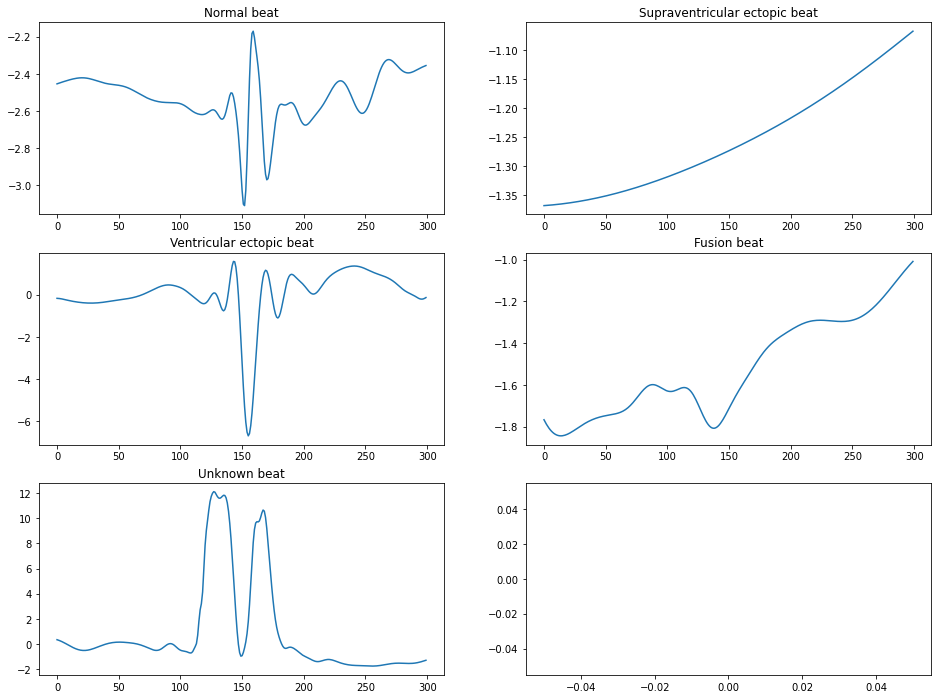

In [134]:
#plotting differents beats
fig, ax = plt.subplots(3,2, figsize=(16,12))
ax[0][0].plot(dict_signals_train_dwt['N'][0])
ax[0][0].set_title('Normal beat')
ax[0][1].plot(dict_signals_train_dwt['S'][0])
ax[0][1].set_title('Supraventricular ectopic beat')
ax[1][0].plot(dict_signals_train_dwt['V'][0])
ax[1][0].set_title('Ventricular ectopic beat')
ax[1][1].plot(dict_signals_train_dwt['F'][0])
ax[1][1].set_title('Fusion beat')
ax[2][0].plot(dict_signals_train_dwt['Q'][0])
ax[2][0].set_title('Unknown beat')
ax[2][1].plot()

<div class="alert alert-block alert-info">
    <h1>Extracting features using DWT </h1>
</div>

In [10]:
#entropy values can be taken as a measure of complexity of the signal.
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy    

#values of percentiles
def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    kurtosis = stats.kurtosis(list_values)
    skewness =  stats.skew(list_values)
    return [n5, n25, n75, n95, median, mean, std, var, rms, kurtosis, skewness]

#number of times a signal crosses y = 0
#number of times a signal crosses y = mean(y)
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

#call the other functions
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

#applying the features extraction
def applying_extracting_features(dict_of_signals, wavelet_function):
    list_labels = [] #list to append type beats
    list_features = [] #list to append values beats

    for keys, values in dict_of_signals.items(): #iterate in dict
        for beat in values: #iterate of all beats
            features = [] #list to append features of each coefficients
            list_labels.append(keys) #append the respective key of beats
            list_coeff = pywt.wavedec(beat, wavelet_function) #extracting the coefficients
            for coeff in list_coeff: #iterate of all coefficients
                features += get_features(coeff) #append all features of one beat
            list_features.append(features) #append the features of beat

    df_signals = pd.DataFrame(list_features) #creating the dataframe
    label_type = 'type_beat'
    df_signals.loc[:,label_type] = list_labels #append the type beats
    
    return df_signals    

In [87]:
#extracting features in beats using dwt db4 family to denoise
#with kurtosis and skewenes and non-normalized signals and mother wavelet db4

df_signals_train_dwt = applying_extracting_features(dict_signals_train_dwt2,'db4')
df_signals_train_dwt.to_csv('./dataset/MIT_feat_extracted/non_normalization/df_beats_train_dwt_db4.csv')
df_signals_test_dwt = applying_extracting_features(dict_signals_test_dwt2,'db4')
df_signals_test_dwt.to_csv('./dataset/MIT_feat_extracted/non_normalization/df_beats_test_dwt_db4.csv')

In [11]:
#extracting features in beats using dwt db14 family to denoise
#with kurtosis and skewenes and non-normalized signals and mother wavelet db14

df_signals_train_dwt = applying_extracting_features(dict_signals_train_dwt2,'db14')
df_signals_train_dwt.to_csv('./dataset/MIT_feat_extracted/non_normalization/df_beats_train_dwt_db14.csv')
df_signals_test_dwt = applying_extracting_features(dict_signals_test_dwt2,'db14')
df_signals_test_dwt.to_csv('./dataset/MIT_feat_extracted/non_normalization/df_beats_test_dwt_db14.csv')

In [24]:
#extracting features in beats using dwt sym family to denoise
#without kurtosis and skeweness and normalized signals

for wavelet in pywt.wavelist('sym'):
    df_signals_train_dwt = applying_extracting_features(dict_signals_train_dwt,wavelet)
    df_signals_train_dwt.to_csv('./dataset/MIT_feat_extracted/df_beats_train_dwt_'+wavelet+'.csv')
    df_signals_test_dwt = applying_extracting_features(dict_signals_test_dwt,wavelet)
    df_signals_test_dwt.to_csv('./dataset/MIT_feat_extracted/df_beats_test_dwt_'+wavelet+'.csv')

In [136]:
#extracting features in beats using dwt db family to denoise
#without kurtosis and skeweness and normalized signals

for wavelet in pywt.wavelist('db'):
    df_signals_train_dwt = applying_extracting_features(dict_signals_train_dwt,wavelet)
    df_signals_train_dwt.to_csv('./dataset/MIT_feat_extracted/db/df_beats_train_dwt_'+wavelet+'.csv')
    df_signals_test_dwt = applying_extracting_features(dict_signals_test_dwt,wavelet)
    df_signals_test_dwt.to_csv('./dataset/MIT_feat_extracted/db/df_beats_test_dwt_'+wavelet+'.csv')

In [10]:
#extracting features in beats using dwt sym family to denoise
#incluing kurtosis and skeweness and normalized signals

for wavelet in pywt.wavelist('sym'):
    df_signals_train_dwt = applying_extracting_features(dict_signals_train_dwt,wavelet)
    df_signals_train_dwt.to_csv('./dataset/MIT_feat_extracted/kurtosis_skewness/df_beats_train_dwt_'+wavelet+'.csv')
    df_signals_test_dwt = applying_extracting_features(dict_signals_test_dwt,wavelet)
    df_signals_test_dwt.to_csv('./dataset/MIT_feat_extracted/kurtosis_skewness/df_beats_test_dwt_'+wavelet+'.csv')

In [11]:
#extracting features in beats using db sym family to denoise
#incluing kurtosis and skeweness and normalized signals

for wavelet in pywt.wavelist('db'):
    df_signals_train_dwt = applying_extracting_features(dict_signals_train_dwt,wavelet)
    df_signals_train_dwt.to_csv('./dataset/MIT_feat_extracted/kurtosis_skewness/df_beats_train_dwt_'+wavelet+'.csv')
    df_signals_test_dwt = applying_extracting_features(dict_signals_test_dwt,wavelet)
    df_signals_test_dwt.to_csv('./dataset/MIT_feat_extracted/kurtosis_skewness/df_beats_test_dwt_'+wavelet+'.csv')

<div class="alert alert-block alert-info">
    <h1>Data augmentation using SMOTE</h1>
</div>

Using normalized signals, features with kurtosis and skewness, and mother wavelet **db14**

In [4]:
#using beats with dwt sym9 function denoise
df_train_dwt = pd.read_csv(os.path.abspath('./dataset/MIT_feat_extracted/kurtosis_skewness/df_beats_train_dwt_db14.csv'),header=0, index_col=[0])
df_test_dwt = pd.read_csv(os.path.abspath('./dataset/MIT_feat_extracted/kurtosis_skewness/df_beats_test_dwt_db14.csv'),header=0, index_col=[0])

In [5]:
df_train_dwt

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,type_beat
0,4.110874,0,8,-7.672173,-7.213422,-6.850574,-6.669031,-6.913776,-7.033346,0.317713,...,1.509182e-07,1.036591e-04,-3.788151e-11,-9.511617e-11,0.000097,9.391732e-09,0.000035,11.732330,0.060634,N
1,4.110874,0,3,-6.466794,-6.322332,-4.043687,-3.117471,-5.787785,-5.293175,1.193767,...,6.874970e-08,1.516092e-04,7.210608e-10,-6.566464e-11,0.000181,3.273486e-08,0.000054,20.698541,-0.196373,N
2,4.110874,0,2,-2.871717,-2.738528,-2.020162,-1.696004,-2.382530,-2.323096,0.415218,...,2.144614e-08,7.766121e-06,4.642235e-10,-8.522154e-11,0.000104,1.077999e-08,0.000020,46.013433,-1.698332,N
3,4.110874,0,3,-4.894951,-4.654254,-2.948616,-2.777385,-3.536643,-3.735277,0.819295,...,7.273679e-08,7.903596e-05,5.482739e-10,7.452735e-11,0.000077,5.903759e-09,0.000025,22.861240,0.898342,N
4,4.110874,0,1,-4.915987,-4.871489,-3.850489,-2.986130,-4.669955,-4.337704,0.657529,...,4.193305e-08,2.336893e-06,1.029830e-09,-1.778354e-10,0.000076,5.745982e-09,0.000014,46.858179,1.715899,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50993,4.110874,7,7,-1.411141,-0.437564,0.329010,0.364642,0.228301,-0.063234,0.670210,...,6.554186e-08,5.421341e-06,1.996716e-11,-7.354480e-11,0.000207,4.266631e-08,0.000044,42.372928,1.580622,F
50994,4.110874,5,3,-1.595559,-0.323961,0.284924,0.945424,0.174699,-0.059231,0.799537,...,3.977789e-08,3.304632e-06,2.887607e-09,1.164557e-10,0.000091,8.294932e-09,0.000021,33.871481,1.232770,F
50995,4.110874,2,6,-0.465980,-0.170713,-0.126640,0.079331,-0.131893,-0.172144,0.188914,...,1.372384e-08,8.171039e-08,-3.527451e-11,-4.912270e-11,0.000057,3.243582e-09,0.000014,25.894844,1.293199,F
50996,4.110874,2,11,-0.223699,0.183327,0.539470,0.857408,0.369080,0.366712,0.326149,...,1.426369e-07,7.026813e-06,-7.817871e-10,8.446236e-10,0.000213,4.539457e-08,0.000041,46.824845,1.710578,F


In [6]:
#removing classes F and Q
df_train_dwt = df_train_dwt.query('type_beat != ["F","Q"]')
df_test_dwt = df_test_dwt.query('type_beat != ["F","Q"]')

In [7]:
#counting the classes 
Counter(df_train_dwt['type_beat'])

Counter({'N': 45844, 'S': 944, 'V': 3788})

In [8]:
#applying SMOTE in training set of dwt denoise
#sm = SMOTE()
#X_train_dwt_smote, y_train_dwt_smote = sm.fit_resample(df_train_dwt.drop(['type_beat'],axis=1),df_train_dwt['type_beat'])

In [9]:
#applying SMOTE in training set of dwt denoise

pipeline = make_pipeline(SMOTE(sampling_strategy={'N': 45844, 'S': 40000, 'V': 40000}),
                        RandomUnderSampler(sampling_strategy={'N': 15000, 'S': 40000, 'V': 40000}))
X_train_dwt_smote, y_train_dwt_smote = pipeline.fit_resample(df_train_dwt.drop(['type_beat'],axis=1),df_train_dwt['type_beat'])

In [10]:
Counter(y_train_dwt_smote)

Counter({'N': 15000, 'S': 40000, 'V': 40000})

In [11]:
#splitting the test dataframe in data and target
X_test_dwt, y_test_dwt = df_test_dwt.drop(['type_beat'],axis=1),df_test_dwt['type_beat']

In [12]:
Counter(y_test_dwt)

Counter({'N': 44238, 'S': 1837, 'V': 3220})

In [13]:
#reshape the dataframes of data and target
X = X_train_dwt_smote.values.astype(float)
y = y_train_dwt_smote.values.squeeze()

In [14]:
#reshape the dataframes of data and target
X_t = X_test_dwt.values.astype(float)
y_t = y_test_dwt.values.squeeze()

In [15]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_y)

In [16]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_t)
encoded_y_test = encoder.transform(y_t)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

<div class="alert alert-block alert-info">
    <h1>Classification</h1>
</div>

# Gradient Boosting

In [38]:
#fitting the classifier
grad_boost = GradientBoostingClassifier(n_estimators=200)
grad_boost.fit(X_train_dwt_smote,y_train_dwt_smote)

GradientBoostingClassifier(n_estimators=200)

In [57]:
#getting the score of training set
train_score = grad_boost.score(X_train_dwt_smote,y_train_dwt_smote)
test_score = grad_boost.score(X_test_dwt,y_test_dwt)
print(f'The train score is {train_score}')
print(f'The test score is {test_score}')

The train score is 0.9235894736842105
The test score is 0.611279034384826


In [58]:
y_train_pred_grd = grad_boost.predict(X_train_dwt_smote)
y_test_pred_grd = grad_boost.predict(X_test_dwt)

In [59]:
#getting the report of training set

print('REPORT OF TRAINING SET')
print(classification_report(y_train_dwt_smote,y_train_pred_grd))

REPORT OF TRAINING SET
              precision    recall  f1-score   support

           N       0.91      0.79      0.85     15000
           S       0.90      0.96      0.93     40000
           V       0.95      0.93      0.94     40000

    accuracy                           0.92     95000
   macro avg       0.92      0.90      0.91     95000
weighted avg       0.92      0.92      0.92     95000



In [60]:
#getting the report of test set

print('REPORT OF TEST SET')
print(classification_report(y_test_dwt,y_test_pred_grd))

REPORT OF TEST SET
              precision    recall  f1-score   support

           N       0.96      0.62      0.75     44238
           S       0.09      0.49      0.16      1837
           V       0.17      0.62      0.27      3220

    accuracy                           0.61     49295
   macro avg       0.41      0.57      0.39     49295
weighted avg       0.88      0.61      0.70     49295



Text(609.9818181818181, 0.5, 'True label')

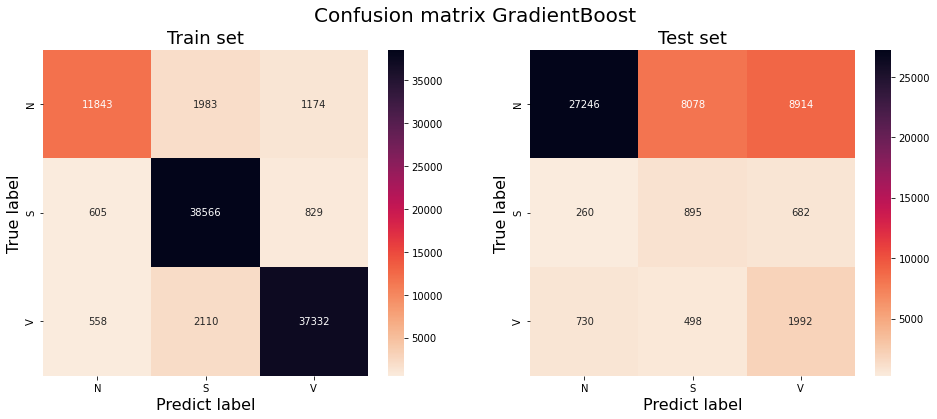

In [61]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_grd = confusion_matrix(y_train_dwt_smote,y_train_pred_grd,labels=grad_boost.classes_)
matrix_test_grd = confusion_matrix(y_test_dwt,y_test_pred_grd,labels=grad_boost.classes_)

sns.heatmap(matrix_train_grd, ax=ax[0],
            xticklabels=grad_boost.classes_, 
            yticklabels=grad_boost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_grd, ax=ax[1],
            xticklabels=grad_boost.classes_, 
            yticklabels=grad_boost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix GradientBoost', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

# XGradient Boost

In [39]:
scv =  StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores_ = {'accuracy' : metrics.make_scorer(metrics.accuracy_score),
           'recall'   : metrics.make_scorer(metrics.recall_score, average='weighted', zero_division=0),
           'precision': metrics.make_scorer(metrics.precision_score, average='weighted', zero_division=0),
           'f1'       : metrics.make_scorer(metrics.fbeta_score, beta = 2, average='weighted' )}

In [40]:
xgboost = xgb.XGBClassifier(n_estimator=200, 
                            random_state=1, 
                            n_jobs=-1,                             
                            learning_rate=0.1)

In [64]:
xgboost_result = cross_validate(xgboost, 
                                X_train_dwt_smote, 
                                y_train_dwt_smote, 
                                scoring=scores_, 
                                cv=scv, 
                                n_jobs=-1,
                                return_train_score=True)

In [65]:
print('Metrics using 10-fold validation')
print(f"Accuracy: {xgboost_result['test_accuracy'].mean():.2f}")
print(f"Recall: {xgboost_result['test_recall'].mean():.2f}")
print(f"Accuracy: {xgboost_result['test_precision'].mean():.2f}")
print(f"Accuracy: {xgboost_result['test_f1'].mean():.2f}")

Metrics using 10-fold validation
Accuracy: 0.96
Recall: 0.96
Accuracy: 0.96
Accuracy: 0.96


In [41]:
xgboost.fit(X_train_dwt_smote,y_train_dwt_smote)

/media/share/comum/env/cisco/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:30:25] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:30:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=200, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [67]:
train_pred_xgb = xgboost.predict(X_train_dwt_smote)
test_pred_xgb = xgboost.predict(X_test_dwt)

In [68]:
print(classification_report(y_train_dwt_smote, train_pred_xgb))

              precision    recall  f1-score   support

           N       0.97      0.90      0.94     15000
           S       0.96      0.99      0.98     40000
           V       0.98      0.97      0.98     40000

    accuracy                           0.97     95000
   macro avg       0.97      0.96      0.96     95000
weighted avg       0.97      0.97      0.97     95000



In [69]:
print(classification_report(y_test_dwt, test_pred_xgb))

              precision    recall  f1-score   support

           N       0.96      0.71      0.81     44238
           S       0.11      0.39      0.17      1837
           V       0.20      0.61      0.30      3220

    accuracy                           0.69     49295
   macro avg       0.42      0.57      0.43     49295
weighted avg       0.88      0.69      0.76     49295



Text(609.9818181818181, 0.5, 'True label')

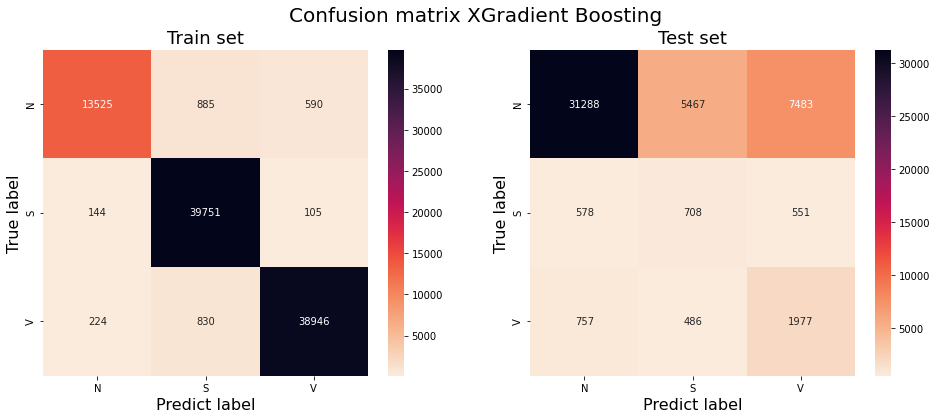

In [70]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_xgb = confusion_matrix(y_train_dwt_smote, train_pred_xgb, labels=xgboost.classes_)
matrix_test_xgb = confusion_matrix(y_test_dwt, test_pred_xgb, labels=xgboost.classes_)

sns.heatmap(matrix_train_xgb, ax=ax[0],
            xticklabels=xgboost.classes_, 
            yticklabels=xgboost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_xgb, ax=ax[1],
            xticklabels=xgboost.classes_, 
            yticklabels=xgboost.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix XGradient Boosting', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)
#plt.savefig(os.path.abspath('./images/confusion_xgradient_boosting.pdf'), dpi=300)

# SVM

In [60]:
def gridSearchCV(X,y,type_grid):    

    #setting parameters
    parameters = {'C':np.arange(0.1,0.4,0.025), 'kernel':['rbf'], 'gamma':['scale','auto',0.1,0.2,0.3]}
    
    #creating model with pipeline 
    model = SVC()

    #creating a dictionary of metrics
    scores_ = {'accuracy' : metrics.make_scorer(metrics.accuracy_score),
               'recall'   : metrics.make_scorer(metrics.recall_score, average='weighted', zero_division=0),
               'precision': metrics.make_scorer(metrics.precision_score, average='weighted', zero_division=0),
               'f1'       : metrics.make_scorer(metrics.fbeta_score, beta = 2, average='weighted' )} #beta >1 favors recall

    #instantiate the GridSearch with pipeline and parameters
    #the parameter *scoring* will calculate all metrics define in dictionary
    #the parameter *refit* will tell the grid which metrics will be used as best parameter
    #the parameter *cv* use the StratifiedKFold (The folds are made by preserving the percentage of samples for each class.)
    if type_grid == 'grid':        
        grid = GridSearchCV(model,
                            param_grid=parameters, 
                            cv=10, 
                            n_jobs=-1, 
                            scoring=scores_, 
                            refit='f1',
                            return_train_score=True)
    else:
        grid = RandomizedSearchCV(model, 
                                  param_distributions=parameters, 
                                  n_iter=10, 
                                  cv=10, 
                                  n_jobs=-1,
                                  scoring=scores_, 
                                  refit='f1',
                                  return_train_score=True)

    #training the model using the training set
    grid.fit(X, y)
    
    #taking the best F1 score
    #print(f'Best_score: {grid.best_score_}')
    print(f'Best_score: {grid.best_score_}')
    
    #taking the best score
    print(f'Best_param: {grid.best_params_}')
    
    results = pd.DataFrame(grid.cv_results_)[['params',
                                                         'mean_train_accuracy',
                                                         'mean_train_recall',
                                                         'mean_train_precision',
                                                         'mean_train_f1',
                                                         'mean_test_accuracy',
                                                         'mean_test_recall',
                                                         'mean_test_precision',
                                                         'mean_test_f1']].sort_values(by=['mean_test_f1'], ascending=False)  
    return results, grid

In [42]:
#fitting the svm with training set
svm_scaler = SVC(C=13.4, 
                 kernel='rbf', 
                 gamma=0.2)

In [73]:
svm_result = cross_validate(svm_scaler, 
                            X_train_dwt_smote, 
                            y_train_dwt_smote, 
                            scoring=scores_, 
                            cv=scv, 
                            n_jobs=-1,
                            return_train_score=True)

In [74]:
print('Metrics using 10-fold validation')
print(f"Accuracy: {svm_result['test_accuracy'].mean():.2f}")
print(f"Recall: {svm_result['test_recall'].mean():.2f}")
print(f"Accuracy: {svm_result['test_precision'].mean():.2f}")
print(f"Accuracy: {svm_result['test_f1'].mean():.2f}")

Metrics using 10-fold validation
Accuracy: 0.83
Recall: 0.83
Accuracy: 0.88
Accuracy: 0.81


In [43]:
svm_scaler.fit(X_train_dwt_smote,y_train_dwt_smote)

SVC(C=13.4, gamma=0.2)

In [76]:
train_score_svm = svm_scaler.score(X_train_dwt_smote,y_train_dwt_smote)
print(f'The train score is {train_score_svm}')

The train score is 1.0


In [77]:
train_pred_svm = svm_scaler.predict(X_train_dwt_smote)
test_pred_svm = svm_scaler.predict(X_test_dwt)

In [79]:
print('REPORT OF TRAINING SET')
print(classification_report(y_train_dwt_smote,train_pred_svm))

REPORT OF TRAINING SET
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     15000
           S       1.00      1.00      1.00     40000
           V       1.00      1.00      1.00     40000

    accuracy                           1.00     95000
   macro avg       1.00      1.00      1.00     95000
weighted avg       1.00      1.00      1.00     95000



In [80]:
print('REPORT OF TEST SET')
print(classification_report(y_test_dwt,test_pred_svm))

REPORT OF TEST SET
              precision    recall  f1-score   support

           N       0.85      0.02      0.03     44238
           S       0.00      0.00      0.00      1837
           V       0.06      0.96      0.12      3220

    accuracy                           0.08     49295
   macro avg       0.30      0.33      0.05     49295
weighted avg       0.76      0.08      0.04     49295



Text(609.9818181818181, 0.5, 'True label')

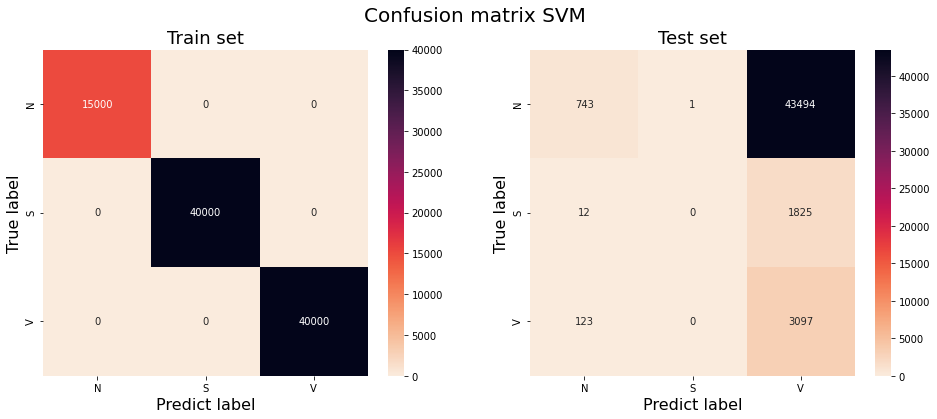

In [82]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_svm = confusion_matrix(y_train_dwt_smote,train_pred_svm,labels=svm_scaler.classes_)
matrix_test_svm = confusion_matrix(y_test_dwt,test_pred_svm,labels=svm_scaler.classes_)

sns.heatmap(matrix_train_svm, ax=ax[0],
            xticklabels=svm_scaler.classes_, 
            yticklabels=svm_scaler.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_svm, ax=ax[1],
            xticklabels=svm_scaler.classes_, 
            yticklabels=svm_scaler.classes_,
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix SVM', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

# Neural Networks

In [2]:
# define baseline model
def baseline_model(X):
    
    model = Sequential()
    model.add(Dense(10, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [15]:
# define baseline model
#constraint is imposed on the weights for each hidden layer, 
#ensuring that the maximum norm of the weights does not exceed a value of 3.
def baseline_model_2():
    
    model = Sequential()
    model.add(Dense(30, input_shape=(X.shape[1],), activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dense(15, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(5, activation='softmax'))
    model.summary()
    adam = tf.keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [16]:
#stop training when loss has stopped improving after 10 epochs
es = EarlyStopping(monitor='loss', 
                   mode='min',
                   patience=10, 
                   restore_best_weights=True) 

In [17]:
model = baseline_model(X)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                570       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


In [18]:
X.shape

(95000, 56)

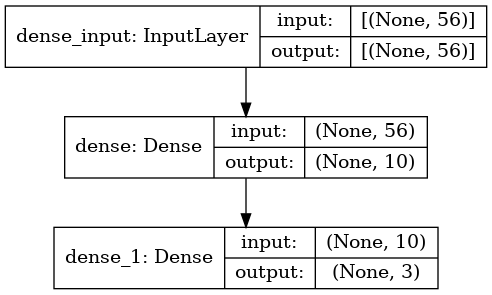

In [19]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
history = model.fit(X, 
                    dummy_y, 
                    epochs=8000000, 
                    callbacks=[es], 
                    batch_size=128, 
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/8000000
594/594 [==============================] - 3s 3ms/step - loss: 1.9646 - accuracy: 0.5627 - val_loss: 0.7290 - val_accuracy: 0.7337
Epoch 2/8000000
594/594 [==============================] - 2s 3ms/step - loss: 0.6506 - accuracy: 0.7344 - val_loss: 0.5878 - val_accuracy: 0.7809
Epoch 3/8000000
594/594 [==============================] - 2s 3ms/step - loss: 0.5951 - accuracy: 0.7640 - val_loss: 0.5154 - val_accuracy: 0.8032
Epoch 4/8000000
594/594 [==============================] - 2s 3ms/step - loss: 0.5719 - accuracy: 0.7760 - val_loss: 0.6893 - val_accuracy: 0.7358
Epoch 5/8000000
594/594 [==============================] - 2s 3ms/step - loss: 0.5555 - accuracy: 0.7799 - val_loss: 0.5115 - val_accuracy: 0.8093
Epoch 6/8000000
594/594 [==============================] - 2s 3ms/step - loss: 0.5407 - accuracy: 0.7911 - val_loss: 0.5600 - val_accuracy: 0.7843
Epoch 7/8000000
594/594 [==============================] - 2s 3ms/step - loss: 0.5302 - accuracy: 0.7959 - val_loss: 0

In [20]:
#model = load_model("model.h5")

In [26]:
model.save("model.h5")

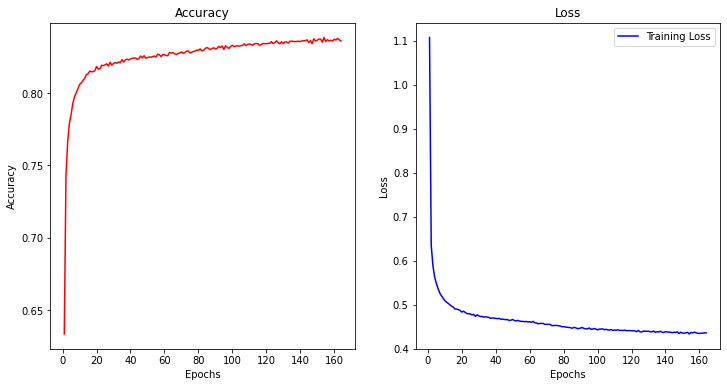

In [27]:
history_dict = history.history

# learning curves
acc = history_dict['accuracy']
loss = history_dict['loss']
epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[1].plot(epochs, loss, 'b', label='Training Loss')

ax[0].set_title('Accuracy')
ax[1].set_title('Loss')

ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')

ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')

plt.legend()
plt.show()

In [29]:
# make class predictions with the model
train_pred = model.predict(X)
test_pred = model.predict(X_t)

In [30]:
#getting the report of training set
print(classification_report(dummy_y.argmax(axis=1), train_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     15000
           1       0.80      0.89      0.84     40000
           2       0.95      0.83      0.89     40000

    accuracy                           0.84     95000
   macro avg       0.81      0.81      0.81     95000
weighted avg       0.85      0.84      0.84     95000



In [31]:
print(classification_report(dummy_y_test.argmax(axis=1), test_pred.argmax(axis=1), zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.53      0.69     44238
           1       0.08      0.68      0.14      1837
           2       0.19      0.51      0.27      3220

    accuracy                           0.54     49295
   macro avg       0.41      0.57      0.37     49295
weighted avg       0.88      0.54      0.64     49295



Text(609.9818181818181, 0.5, 'True label')

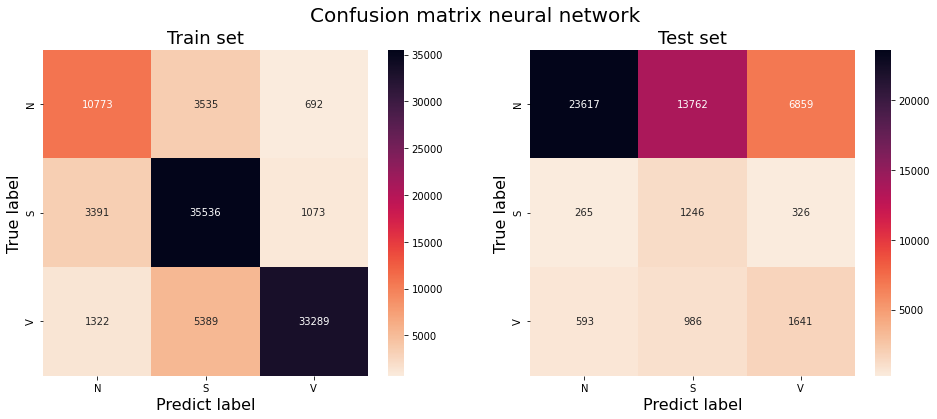

In [33]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

matrix_train_ann = confusion_matrix(dummy_y.argmax(axis=1), train_pred.argmax(axis=1)) 
matrix_test_ann = confusion_matrix(dummy_y_test.argmax(axis=1), test_pred.argmax(axis=1))

sns.heatmap(matrix_train_ann, ax=ax[0],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r',)
sns.heatmap(matrix_test_ann, ax=ax[1],
            xticklabels=['N','S','V'], 
            yticklabels=['N','S','V'],
            annot=True, 
            fmt='.0f', 
            cmap='rocket_r')
plt.suptitle('Confusion matrix neural network', fontsize=20)
ax[0].set_title('Train set', fontsize=18)
ax[0].set_xlabel('Predict label', fontsize=16)
ax[0].set_ylabel('True label', fontsize=16)
ax[1].set_title('Test set', fontsize=18)
ax[1].set_xlabel('Predict label', fontsize=16)
ax[1].set_ylabel('True label', fontsize=16)

In [34]:
# Compute ROC curve and ROC area for each class
def plot_roc_auc_curve(y_test, y_score_decision, classes, classifier):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i, cls in enumerate(classes):
        fpr[cls], tpr[cls], _ = roc_curve(y_test[:, i], y_score_decision[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Compute micro-average ROC curve and ROC area
    # ravel return a flatten array of dataframe
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_decision.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure(figsize=(9,6))
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro média (área = {roc_auc["micro"]:.2f})', linewidth=4)
    
    for i in classes:
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (área = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Curva ROC '+ classifier)
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('./images/roc_auc_'+classifier+'.pdf'), dpi=300)
    plt.show()

In [51]:
# Compute ROC curves for all classifiers
def plot_all_roc_auc_curves(y_test, y_score_decision, classifiers):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    # ravel return a flatten array of dataframe    
    for decision, classifiers_ in zip(y_score_decision,classifiers):
        fpr[classifiers_], tpr[classifiers_], _ = roc_curve(y_test.ravel(), decision.ravel())
        roc_auc[classifiers_] = auc(fpr[classifiers_], tpr[classifiers_])

    # Plot ROC curve
    plt.figure(figsize=(12,8))
    
    for classifiers_ in classifiers:
        plt.plot(fpr[classifiers_], tpr[classifiers_], label=f'{classifiers_} (área = {roc_auc[classifiers_]:.2f})', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Comparativos de Curvas ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.savefig(os.path.abspath('./images/roc_auc_all_smote_norm.pdf'), dpi=300)
    plt.show()

In [44]:
dec_funct_xgb = xgboost.predict_proba(X_test_dwt)
dec_funct_grd = grad_boost.decision_function(X_test_dwt)
dec_funct_svm = svm_scaler.decision_function(X_test_dwt)
dec_funct_ann = model.predict_proba(X_test_dwt)

/media/share/comum/env/cisco/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


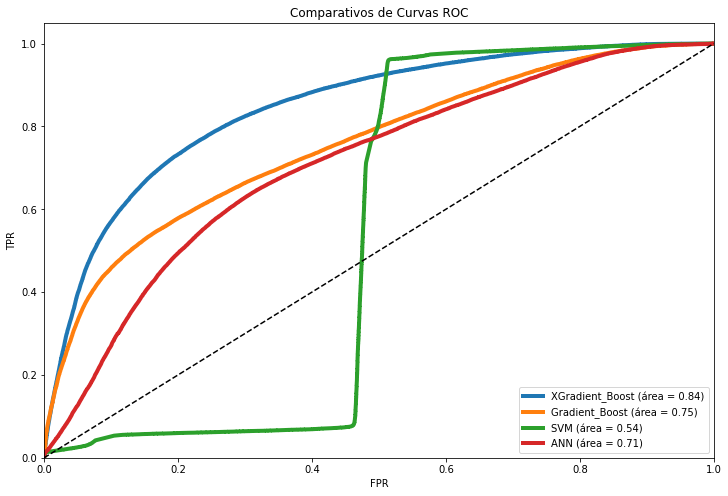

In [58]:
classifiers = ['XGradient_Boost','Gradient_Boost','SVM', 'ANN']
dec_functs = [dec_funct_xgb, dec_funct_grd, dec_funct_svm, dec_funct_ann]

plot_all_roc_auc_curves(dummy_y_test, dec_functs, classifiers)